# Modeling and Evaluation

## 1. Import Required Packages

In [1]:
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("expand_frame_repr", True)
pd.set_option("max_colwidth", None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

## 2. Import Data

### 2.1 Imbalanced Datasets

In [2]:
X_train = np.load("data/Original/X_train.npy")
y_train = np.load("data/Original/y_train.npy")
X_val = np.load("data/Original/X_val.npy")
y_val = np.load("data/Original/y_val.npy")

In [3]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((208480, 68), (208480,), (52121, 68), (52121,))

### 2.2 Undersampled Datasets

In [4]:
X_train_under_sample = np.load("data/UnderSampling/X_train_undersample.npy")
y_train_under_sample = np.load("data/UnderSampling/y_train_undersample.npy")

### 2.3 Oversampled Datasets

In [5]:
X_train_over_sample = np.load("data/OverSampling/X_train_oversample.npy")
y_train_over_sample = np.load("data/OverSampling/y_train_oversample.npy")

### 2.4 SMOTE Datasets

In [6]:
X_train_smote = np.load("data/SMOTE/X_train_smote.npy")
y_train_smote = np.load("data/SMOTE/y_train_smote.npy")

### Helper Evaluation function to give all metrics after model Training

In [7]:
def evaluate_model(true, predicted, test=False):
    """
    Generate the confusion matrix and classification report
    """
    if test:
        cm = confusion_matrix(true, predicted)
        cr = classification_report(true, predicted)
        conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                             index=['Actual:1','Actual:2','Actual:3'])
        # confusion matrix in heatmap
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        print(cr) 
    f1_micro = f1_score(true, predicted, average='micro')
    return f1_micro


# 3. Modeling with Decision Tree

### Helper for Tracking Experiment Results

In [9]:
import os
def write_results(results):
    # Path to the CSV file
    csv_file = "RandomForest_results.csv"

    # Check if the file exists, if not create a new one with headers
    if not os.path.isfile(csv_file):
        results.to_csv(csv_file, header=True, index=False)
    else:
        # Append the results to the CSV file
        results.to_csv(csv_file, mode='a', header=False, index=False)

In [10]:
results_df = pd.DataFrame(columns=['Dataset', 'Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter'])

### Helper For Training and Evalution of Decision Tree 

In [11]:
def train_and_evaluate_(X_train, y_train):    
    model_list = []
    model_parameters = []
    f1_micro_train = []
    f1_micro_val = []
    time_taken = []
    
    # start time
    start_time = time.time()

    model_parameters.append({'max_depth':model.get_params()['max_depth'],'min_samples_split':model.get_params()['min_samples_split'],
                             'class_weight':model.get_params()['class_weight']})

    model.fit(X_train, y_train)

    # end time
    end_time = time.time()

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    model_list.append(model.__class__.__name__)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))

    f1_micro_train.append(model_train_f1)
    f1_micro_val.append(model_val_f1)
    time_ellapsed = np.round(end_time - start_time, 2)
    time_taken.append(time_ellapsed)

    print('='*35)
    print('\n')

    results = pd.DataFrame(list(zip(model_list, f1_micro_train, f1_micro_val, time_taken, model_parameters)), 
                           columns=['Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro-Averaged F1-Score"],ascending=False)
    # write_results(results)
    return results

datasets = [("Original", X_train, y_train), ("UnderSampling", X_train_under_sample, y_train_under_sample), ("OverSampling", X_train_over_sample, y_train_over_sample), ("SMOTE", X_train_smote, y_train_smote)]

def display_evaluation_results():
    global results_df
    for dataset_name, X_train, y_train in datasets:
        print(f"Training on dataset: {dataset_name}")
        results = train_and_evaluate_(X_train, y_train)
        results['Dataset'] = dataset_name
        results_df = results_df.append(results, ignore_index=True)
    
    write_results(results_df)
    return results_df

### Initialize Decision Tree Model

In [12]:
model = DecisionTreeClassifier(max_depth=15, min_samples_split=30, random_state=42) # max_depth=15, min_samples_split=30

### Finally, Train And Evalute the Model on different Datasets :)

Training on dataset: Original


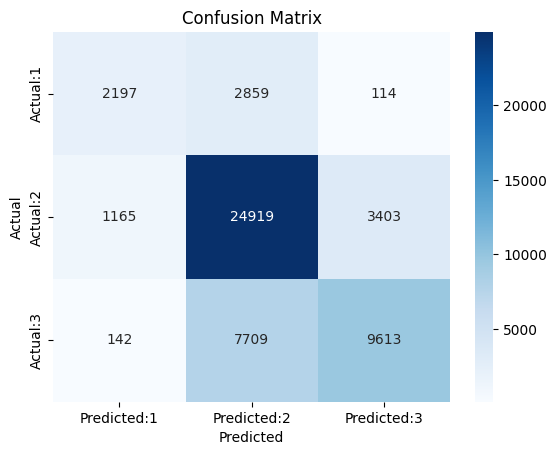

              precision    recall  f1-score   support

           0       0.63      0.42      0.51      5170
           1       0.70      0.85      0.77     29487
           2       0.73      0.55      0.63     17464

    accuracy                           0.70     52121
   macro avg       0.69      0.61      0.63     52121
weighted avg       0.70      0.70      0.69     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7404
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7047


Training on dataset: UnderSampling


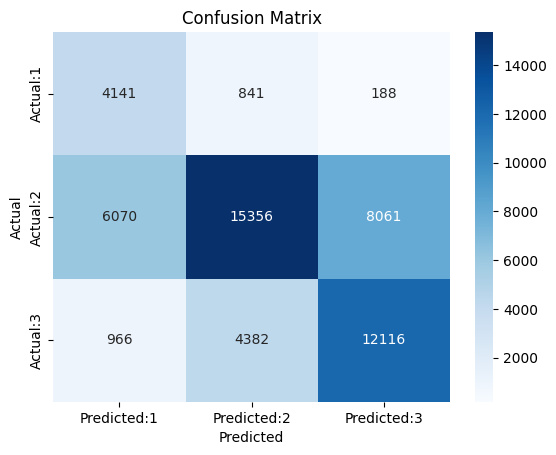

              precision    recall  f1-score   support

           0       0.37      0.80      0.51      5170
           1       0.75      0.52      0.61     29487
           2       0.59      0.69      0.64     17464

    accuracy                           0.61     52121
   macro avg       0.57      0.67      0.59     52121
weighted avg       0.66      0.61      0.61     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7416
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6065


Training on dataset: OverSampling


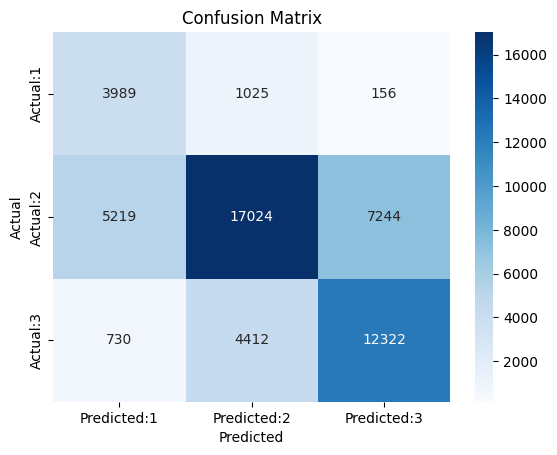

              precision    recall  f1-score   support

           0       0.40      0.77      0.53      5170
           1       0.76      0.58      0.66     29487
           2       0.62      0.71      0.66     17464

    accuracy                           0.64     52121
   macro avg       0.59      0.68      0.62     52121
weighted avg       0.68      0.64      0.65     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7482
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6396


Training on dataset: SMOTE


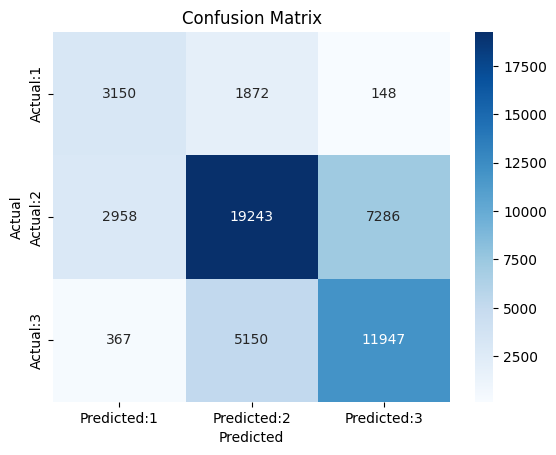

              precision    recall  f1-score   support

           0       0.49      0.61      0.54      5170
           1       0.73      0.65      0.69     29487
           2       0.62      0.68      0.65     17464

    accuracy                           0.66     52121
   macro avg       0.61      0.65      0.63     52121
weighted avg       0.67      0.66      0.66     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7657
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6589




,Dataset,Model Name,Train Micro-Averaged F1-Score,Val Micro-Averaged F1-Score,Time,Parameter
0,Original,DecisionTreeClassifier,0.740397,0.704687,2.91,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"
1,UnderSampling,DecisionTreeClassifier,0.741606,0.606531,0.73,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"
2,OverSampling,DecisionTreeClassifier,0.748209,0.639569,5.34,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"
3,SMOTE,DecisionTreeClassifier,0.765694,0.658852,7.21,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"


In [13]:
display_evaluation_results()

## Let's perform Hyperparameter Tuning on our DecisionTreeClassifier

### I. Using Grid Search CV 

In [ ]:
def train_and_evaluate_with_tuning_(X_train, y_train):
    # Create the hyperparameter grid
    param_grid = {
        "max_depth": [5, 10, 15, 20, 30],
        "min_samples_split": [10, 20, 30, 40, 50],
        "class_weight": ['balanced', None],
    }

    # Create the grid search object
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42), param_grid, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the grid search object to the training data
    grid_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", grid_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = grid_search.best_estimator_.predict(X_val)
    
    y_train_pred = grid_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, grid_search.best_params_]], columns=['Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

### Evaluation Result on different Datasets

Best parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_split': 50}


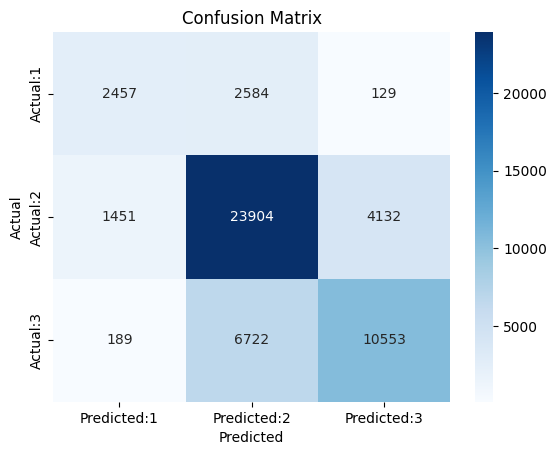

              precision    recall  f1-score   support

           1       0.60      0.48      0.53      5170
           2       0.72      0.81      0.76     29487
           3       0.71      0.60      0.65     17464

    accuracy                           0.71     52121
   macro avg       0.68      0.63      0.65     52121
weighted avg       0.71      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7624
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7082
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.762375,0.708237,353.38,"{'class_weight': None, 'max_depth': 20, 'min_s..."


In [117]:
train_and_evaluate_with_tuning_(X_train, y_train)

Best parameters: {'class_weight': None, 'max_depth': 15, 'min_samples_split': 40}


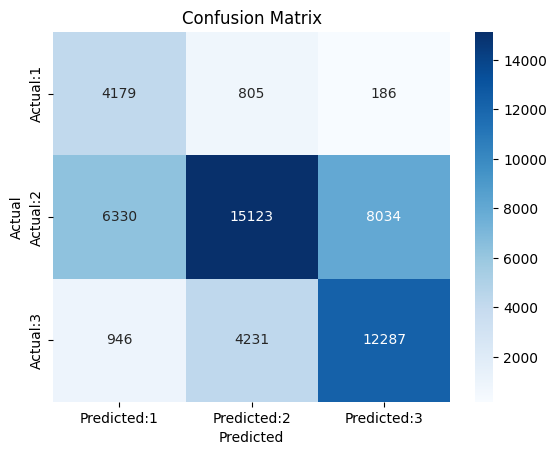

              precision    recall  f1-score   support

           1       0.36      0.81      0.50      5170
           2       0.75      0.51      0.61     29487
           3       0.60      0.70      0.65     17464

    accuracy                           0.61     52121
   macro avg       0.57      0.67      0.59     52121
weighted avg       0.66      0.61      0.61     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7352
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6061
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.735241,0.60607,78.88,"{'class_weight': None, 'max_depth': 15, 'min_s..."


In [118]:
train_and_evaluate_with_tuning_(X_train_under_sample, y_train_under_sample)

Best parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 10}


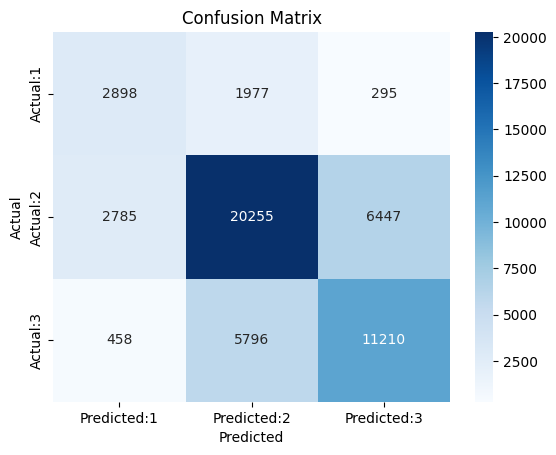

              precision    recall  f1-score   support

           1       0.47      0.56      0.51      5170
           2       0.72      0.69      0.70     29487
           3       0.62      0.64      0.63     17464

    accuracy                           0.66     52121
   macro avg       0.61      0.63      0.62     52121
weighted avg       0.66      0.66      0.66     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9179
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6593
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.917879,0.659293,615.28,"{'class_weight': 'balanced', 'max_depth': 30, ..."


In [119]:
train_and_evaluate_with_tuning_(X_train_over_sample, y_train_over_sample)

Best parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_split': 10}


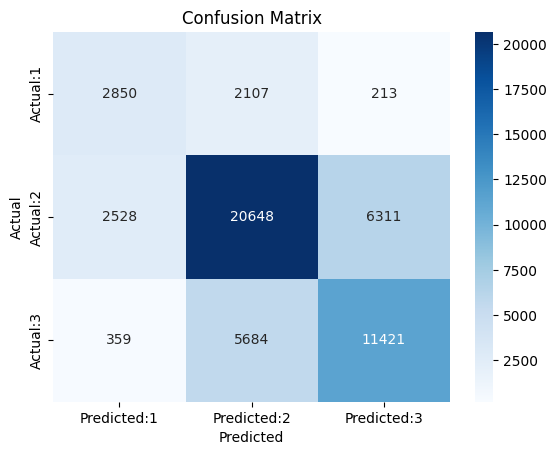

              precision    recall  f1-score   support

           1       0.50      0.55      0.52      5170
           2       0.73      0.70      0.71     29487
           3       0.64      0.65      0.65     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.64      0.63     52121
weighted avg       0.67      0.67      0.67     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8481
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6700
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.848121,0.66996,777.97,"{'class_weight': None, 'max_depth': 20, 'min_s..."


In [120]:
train_and_evaluate_with_tuning_(X_train_smote, y_train_smote)

<br>

### II. With Randomized Search CV

In [15]:
def train_and_evaluate_with_tuning_rs(X_train, y_train):
    
    # Create the hyperparameter space
    param_space = {
        "max_depth": np.arange(5, 31),
        "min_samples_split": np.arange(10, 51),
        "class_weight": ["balanced", None],
    }

    # Create the random search object
    random_search = RandomizedSearchCV(
        DecisionTreeClassifier(random_state=42), param_space, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", random_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = random_search.best_estimator_.predict(X_val)
    
    y_train_pred = random_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

Best parameters: {'min_samples_split': 45, 'max_depth': 30, 'class_weight': None}


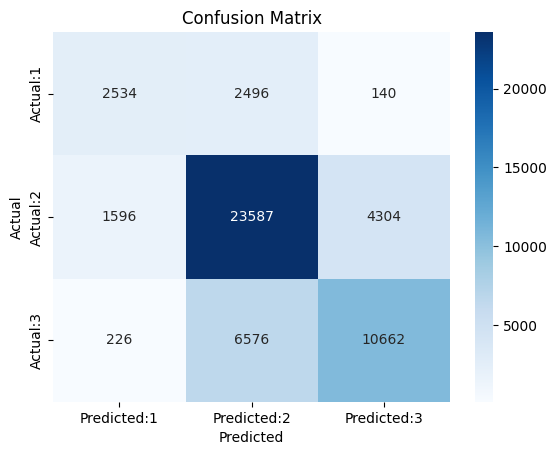

              precision    recall  f1-score   support

           1       0.58      0.49      0.53      5170
           2       0.72      0.80      0.76     29487
           3       0.71      0.61      0.65     17464

    accuracy                           0.71     52121
   macro avg       0.67      0.63      0.65     52121
weighted avg       0.70      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7830
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7057
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.782962,0.705723,74.21,"{'min_samples_split': 45, 'max_depth': 30, 'cl..."


In [18]:
train_and_evaluate_with_tuning_rs(X_train, y_train)

Best parameters: {'min_samples_split': 38, 'max_depth': 15, 'class_weight': 'balanced'}


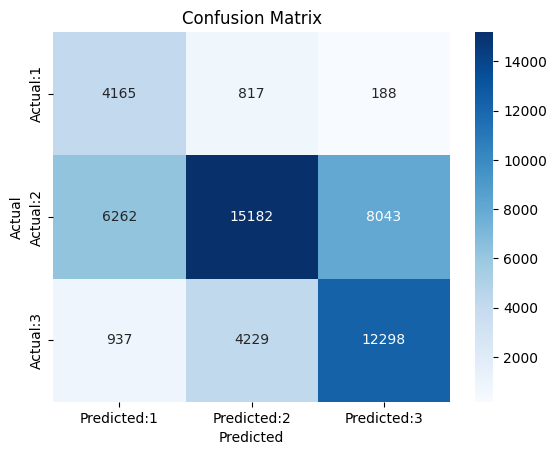

              precision    recall  f1-score   support

           1       0.37      0.81      0.50      5170
           2       0.75      0.51      0.61     29487
           3       0.60      0.70      0.65     17464

    accuracy                           0.61     52121
   macro avg       0.57      0.67      0.59     52121
weighted avg       0.66      0.61      0.61     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7362
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6071
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.736177,0.607145,15.97,"{'min_samples_split': 38, 'max_depth': 15, 'cl..."


In [19]:
train_and_evaluate_with_tuning_rs(X_train_under_sample, y_train_under_sample)

Best parameters: {'min_samples_split': 24, 'max_depth': 24, 'class_weight': None}


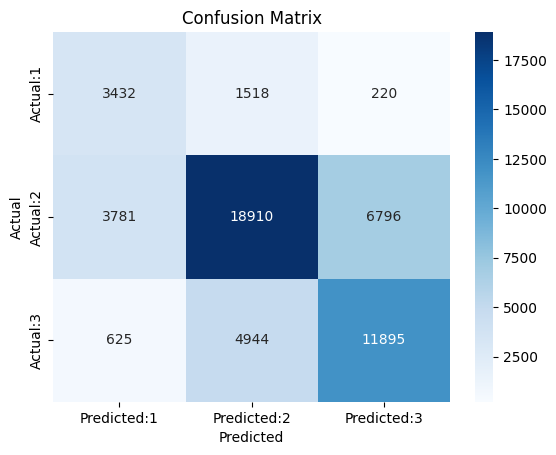

              precision    recall  f1-score   support

           1       0.44      0.66      0.53      5170
           2       0.75      0.64      0.69     29487
           3       0.63      0.68      0.65     17464

    accuracy                           0.66     52121
   macro avg       0.60      0.66      0.62     52121
weighted avg       0.68      0.66      0.66     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8453
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6569
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.845258,0.656875,142.37,"{'min_samples_split': 24, 'max_depth': 24, 'cl..."


In [20]:
train_and_evaluate_with_tuning_rs(X_train_over_sample, y_train_over_sample)

Best parameters: {'min_samples_split': 23, 'max_depth': 23, 'class_weight': None}


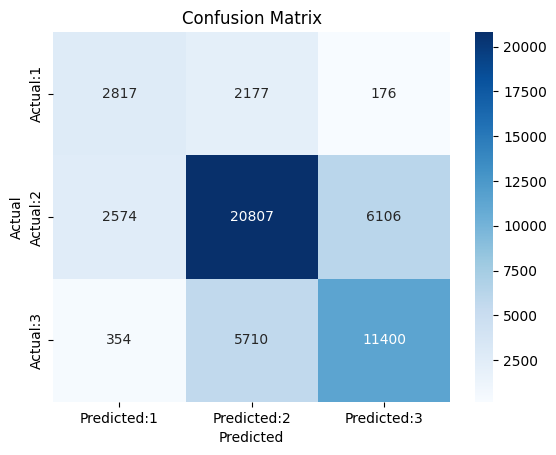

              precision    recall  f1-score   support

           1       0.49      0.54      0.52      5170
           2       0.73      0.71      0.72     29487
           3       0.64      0.65      0.65     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.63      0.63     52121
weighted avg       0.67      0.67      0.67     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8474
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6720
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.847352,0.671975,181.17,"{'min_samples_split': 23, 'max_depth': 23, 'cl..."


In [22]:
train_and_evaluate_with_tuning_rs(X_train_smote, y_train_smote)

## Optimization to reduce Overfitting

### I. Pruning

In [26]:
def prune_decision_tree(tree, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1):
    """Prune a decision tree.

    Args:
    tree: The decision tree to prune.
    criterion: The criterion to use for pruning.
    max_depth: The maximum depth of the tree.
    min_samples_split: The minimum number of samples required to split an internal node.
    min_samples_leaf: The minimum number of samples required to be at a leaf node.

    Returns:
    The pruned decision tree.
    """

    # Check if the tree is already pruned.
    if tree.tree_.children_left is None:
        return tree

    # Get the depth of the tree.
    depth = tree.tree_.max_depth

    # If the maximum depth is specified and the tree is deeper than the maximum depth, then prune the tree.
    if max_depth is not None and depth > max_depth:
        tree = prune_decision_tree(tree, criterion, max_depth - 1, min_samples_split, min_samples_leaf)

    # Get the number of leaves in the tree.
    n_leaves = tree.tree_.n_leaves

    # If the minimum number of leaves is specified and the tree has fewer leaves than the minimum number of leaves, then prune the tree.
    if min_samples_leaf is not None and n_leaves < min_samples_leaf:
        tree = prune_decision_tree(tree, criterion, max_depth, min_samples_split, min_samples_leaf)

    # Return the pruned tree.
    return tree 

def prune_tree(tree, criterion, max_depth, min_samples_split, min_samples_leaf):
    """Prune a subtree.

    Args:
    tree: The subtree to prune.
    criterion: The criterion to use for pruning.
    max_depth: The maximum depth of the tree.
    min_samples_split: The minimum number of samples required to split an internal node.
    min_samples_leaf: The minimum number of samples required to be at a leaf node.

    Returns:
    The pruned subtree.
    """

    # If the subtree is a leaf node, then return the subtree.
    if tree.is_leaf:
        return tree

    # If the subtree is at the maximum depth, then return the subtree.
    if max_depth is not None and tree.depth == max_depth:
        return tree

    # Get the criterion value for the subtree.
    criterion_value = tree.value

    # If the criterion value is less than or equal to the minimum criterion value, then prune the subtree.
    if criterion_value <= criterion:
        return DecisionTreeClassifier(
          criterion=criterion,
          max_depth=max_depth,
          min_samples_split=min_samples_split,
          min_samples_leaf=min_samples_leaf,
        )

    # Otherwise, recurse on the left and right subtrees.
    left = prune_tree(tree.children_left, criterion, max_depth, min_samples_split, min_samples_leaf)
    right = prune_tree(tree.children_right, criterion, max_depth, min_samples_split, min_samples_leaf)

    # Return a new tree with the left and right subtrees.
    return DecisionTreeClassifier(
    criterion=criterion,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    children_left=left,
    children_right=right,
    )

def train_and_evaluate_with_tuning_rs_and_pruning(X_train, y_train):
    
    # Create the hyperparameter space
    param_space = {
        "max_depth": np.arange(5, 31),
        "min_samples_split": np.arange(10, 51),
        "class_weight": ["balanced", None],
    }

    # Create the random search object
    random_search = RandomizedSearchCV(
        DecisionTreeClassifier(random_state=42), param_space, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", random_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = random_search.best_estimator_.predict(X_val)
    
    y_train_pred = random_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    # Get the best estimator
    best_estimator = random_search.best_estimator_

    # Prune the tree
    pruned_tree = prune_decision_tree(best_estimator)

    # Evaluate the pruned model on the validation data
    y_val_pred_pruned = pruned_tree.predict(X_val)
    
    y_train_pred_pruned = pruned_tree.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1_pruned = evaluate_model(y_train, y_train_pred_pruned)
    model_val_f1_pruned = evaluate_model(y_val, y_val_pred_pruned, test=True)

    print("Model Performance for Training Set after Pruning")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1_pruned))
    print("--------------------------------------")

    print("Model Performance for Validation Set after Pruning")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1_pruned))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_],
                          ["DecisionTreeClassifier_Pruned", model_train_f1_pruned, model_val_f1_pruned, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

Best parameters: {'min_samples_split': 36, 'max_depth': 20, 'class_weight': None}


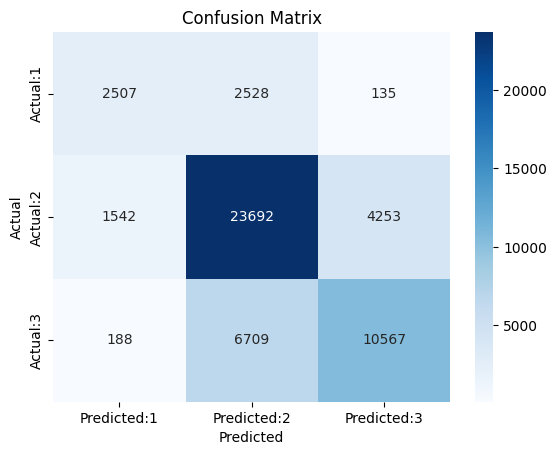

              precision    recall  f1-score   support

           1       0.59      0.48      0.53      5170
           2       0.72      0.80      0.76     29487
           3       0.71      0.61      0.65     17464

    accuracy                           0.71     52121
   macro avg       0.67      0.63      0.65     52121
weighted avg       0.70      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7715
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7054


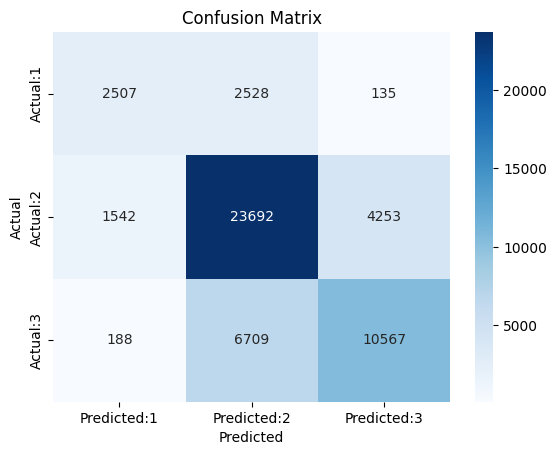

              precision    recall  f1-score   support

           1       0.59      0.48      0.53      5170
           2       0.72      0.80      0.76     29487
           3       0.71      0.61      0.65     17464

    accuracy                           0.71     52121
   macro avg       0.67      0.63      0.65     52121
weighted avg       0.70      0.71      0.70     52121

Model Performance for Training Set after Pruning
F1 Micro-Averaged Score: 0.7715
--------------------------------------
Model Performance for Validation Set after Pruning
F1 Micro-Averaged Score: 0.7054
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.771527,0.705397,83.74,"{'min_samples_split': 36, 'max_depth': 20, 'cl..."
1,DecisionTreeClassifier_Pruned,0.771527,0.705397,83.74,"{'min_samples_split': 36, 'max_depth': 20, 'cl..."


In [27]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train, y_train)

**We can see that Pruning is not making any difference than no pruning**

In [ ]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train_under_sample, y_train_under_sample)

In [ ]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train_over_sample, y_train_over_sample)

Best parameters: {'min_samples_split': 23, 'max_depth': 24, 'class_weight': 'balanced'}


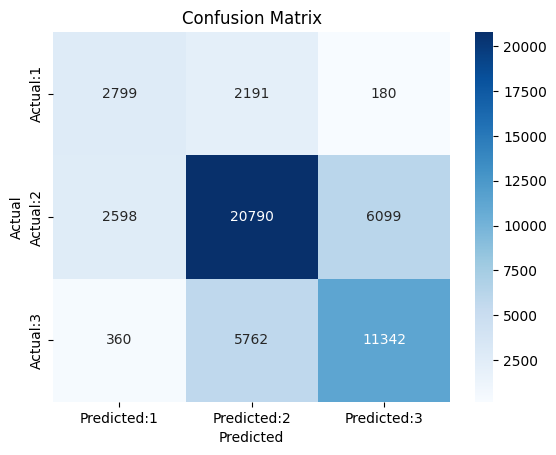

              precision    recall  f1-score   support

           1       0.49      0.54      0.51      5170
           2       0.72      0.71      0.71     29487
           3       0.64      0.65      0.65     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.63      0.62     52121
weighted avg       0.67      0.67      0.67     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8515
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6702


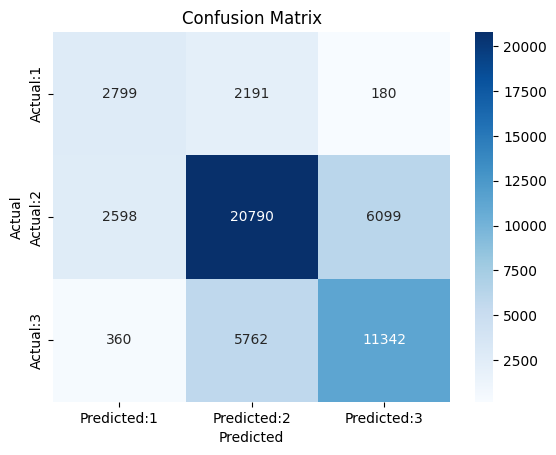

              precision    recall  f1-score   support

           1       0.49      0.54      0.51      5170
           2       0.72      0.71      0.71     29487
           3       0.64      0.65      0.65     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.63      0.62     52121
weighted avg       0.67      0.67      0.67     52121

Model Performance for Training Set after Pruning
F1 Micro-Averaged Score: 0.8515
--------------------------------------
Model Performance for Validation Set after Pruning
F1 Micro-Averaged Score: 0.6702
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.851461,0.670191,175.96,"{'min_samples_split': 23, 'max_depth': 24, 'cl..."
1,DecisionTreeClassifier_Pruned,0.851461,0.670191,175.96,"{'min_samples_split': 23, 'max_depth': 24, 'cl..."


In [32]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train_smote, y_train_smote)

### Let's see if tuning with other parameters help!

In [37]:
def train_and_evaluate_with_tuning_rs_(X_train, y_train):

    # Create the hyperparameter space
    param_space = {
            "max_depth": np.arange(5, 31),
            "min_samples_split": np.arange(10, 51),
            "min_samples_leaf": np.arange(2, 11),
            "class_weight": ["balanced", None],
            "max_features": [None, "sqrt", "log2"]
        }


    # Create the random search object
    random_search = RandomizedSearchCV(
        DecisionTreeClassifier(random_state=42), param_space, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", random_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = random_search.best_estimator_.predict(X_val)
    
    y_train_pred = random_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

Best parameters: {'min_samples_split': 34, 'min_samples_leaf': 9, 'max_depth': 22, 'class_weight': None}


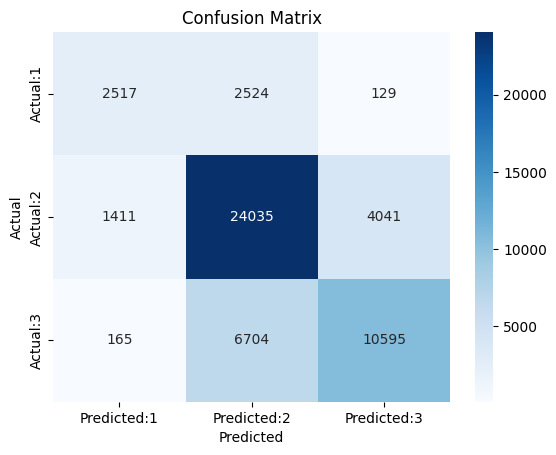

              precision    recall  f1-score   support

           1       0.61      0.49      0.54      5170
           2       0.72      0.82      0.77     29487
           3       0.72      0.61      0.66     17464

    accuracy                           0.71     52121
   macro avg       0.69      0.64      0.66     52121
weighted avg       0.71      0.71      0.71     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7669
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7127
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.766922,0.712707,74.79,"{'min_samples_split': 34, 'min_samples_leaf': ..."


In [34]:
train_and_evaluate_with_tuning_rs_(X_train, y_train) # no max_features 

Best parameters: {'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 26, 'class_weight': 'balanced'}


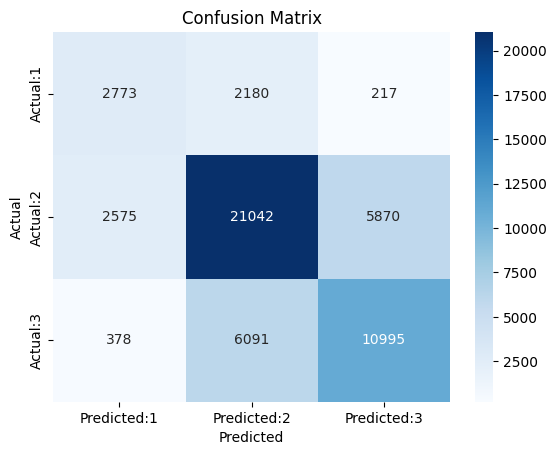

              precision    recall  f1-score   support

           1       0.48      0.54      0.51      5170
           2       0.72      0.71      0.72     29487
           3       0.64      0.63      0.64     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.63      0.62     52121
weighted avg       0.67      0.67      0.67     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8689
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6679
!! Result written to file !!


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.868928,0.667869,108.98,"{'min_samples_split': 11, 'min_samples_leaf': ..."


In [38]:
train_and_evaluate_with_tuning_rs_(X_train_smote, y_train_smote) # with max_features

**We see no difference at all**

## II. Cost complexity pruning 

In [41]:
def train_and_evaluate_with_ccp(X_train, y_train):

    # Define the range of values for ccp_alpha
    ccp_alphas = np.arange(0.0, 1.0, 0.01)

    # Create the decision tree classifier with default hyperparameters
    clf = DecisionTreeClassifier(random_state=42)

    # Create the hyperparameter grid
    param_grid = {
        "ccp_alpha": ccp_alphas,
        "max_depth": [5, 10, 15],
        "min_samples_split": [10, 20, 30],
        "min_samples_leaf": [2, 4, 6],
        "class_weight": ["balanced", None],
        "max_features": [None, "sqrt", "log2"]
    }
    
    # start time
    start_time = time.time()

    # Use 5-fold cross-validation to find the optimal hyperparameters
    cv = GridSearchCV(clf, param_grid=param_grid, cv=5)
    cv.fit(X_train, y_train)
        
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best hyperparameters
    print("Best hyperparameters:", cv.best_params_)

    # Evaluate the model with the best hyperparameters on the validation set
    clf_best = cv.best_estimator_
    y_val_pred = clf_best.predict(X_val)

    y_train_pred = random_search.best_estimator_.predict(X_train)
    
    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier_ccp", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

#### Takes lots of time and computation so we couldn't easily proceed with Cross-Complexity Pruning with CrossValidation!

In [10]:
# train_and_evaluate_with_ccp(X_train, y_train) 

**The cross-validation takes huge computation resources, so we stop Hyperparameter Tuning with CCP in above cell:(**


# 2. Modelling with Random Forest Classifier

In [16]:
# Create the random forest object
rfc = RandomForestClassifier(random_state=42)

In [19]:
def train_and_evaluate_rfc(X_train, y_train):

    # start time
    start_time = time.time()

    # Fit the random forest object to the training data
    rfc.fit(X_train, y_train)
        
    model_params = {'n_estimators':rfc.get_params()['n_estimators'],'max_depth':rfc.get_params()['max_depth'],
                    'max_features':rfc.get_params()['max_features']}
    
    # end time
    end_time = time.time()

    time_ellapsed = np.round(end_time - start_time, 2)

    # Evaluate the random forest object on the validation data
    y_val_pred = rfc.predict(X_val)

    y_train_pred = rfc.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))

    results = pd.DataFrame([["RandomForestClassifier", model_train_f1, model_val_f1, time_ellapsed, model_params]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

<br>

#### Let's see the performance with Random Forest Classifier on different datasets.  Hope to see better evaluation results!

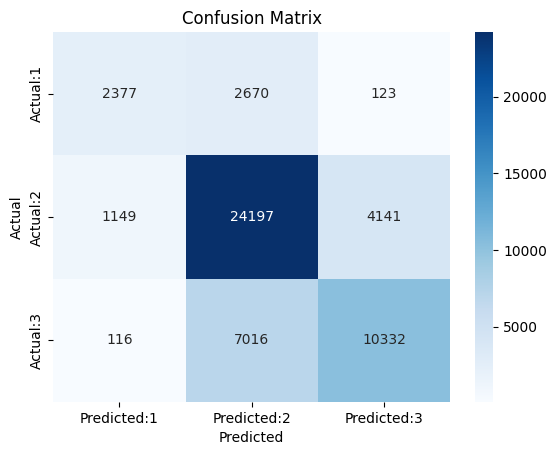

              precision    recall  f1-score   support

           0       0.65      0.46      0.54      5170
           1       0.71      0.82      0.76     29487
           2       0.71      0.59      0.64     17464

    accuracy                           0.71     52121
   macro avg       0.69      0.62      0.65     52121
weighted avg       0.71      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9826
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7081


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,RandomForestClassifier,0.982555,0.708083,62.7,"{'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'}"


In [20]:
train_and_evaluate_rfc(X_train, y_train)

**We see the overfitting in our model ! Let's fix them in our Cross Validation step later..** 

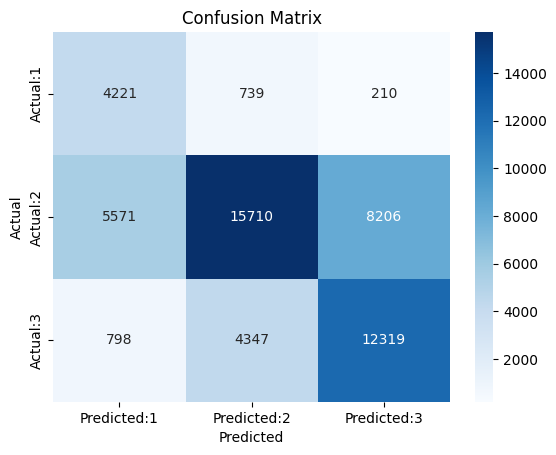

              precision    recall  f1-score   support

           0       0.40      0.82      0.54      5170
           1       0.76      0.53      0.62     29487
           2       0.59      0.71      0.64     17464

    accuracy                           0.62     52121
   macro avg       0.58      0.68      0.60     52121
weighted avg       0.67      0.62      0.62     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9938
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6188


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,RandomForestClassifier,0.993786,0.618753,14.5,"{'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'}"


In [24]:
train_and_evaluate_rfc(X_train_under_sample, y_train_under_sample)

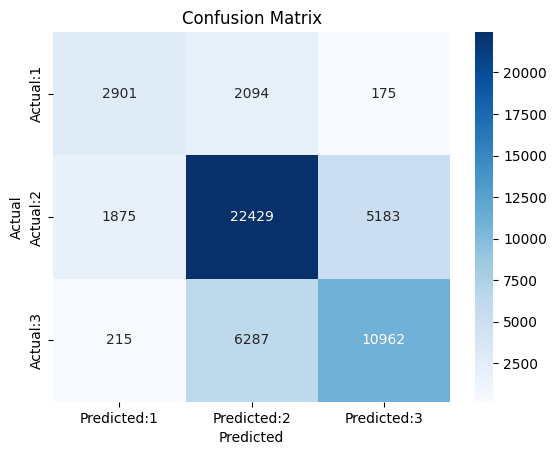

              precision    recall  f1-score   support

           0       0.58      0.56      0.57      5170
           1       0.73      0.76      0.74     29487
           2       0.67      0.63      0.65     17464

    accuracy                           0.70     52121
   macro avg       0.66      0.65      0.65     52121
weighted avg       0.69      0.70      0.69     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9884
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6963


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,RandomForestClassifier,0.988381,0.696303,100.34,"{'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'}"


In [25]:
train_and_evaluate_rfc(X_train_over_sample, y_train_over_sample)

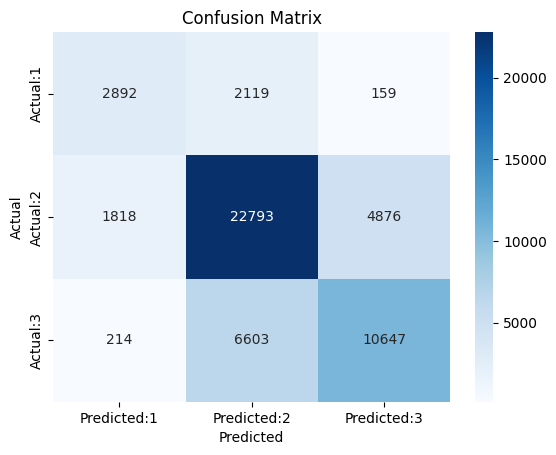

              precision    recall  f1-score   support

           0       0.59      0.56      0.57      5170
           1       0.72      0.77      0.75     29487
           2       0.68      0.61      0.64     17464

    accuracy                           0.70     52121
   macro avg       0.66      0.65      0.65     52121
weighted avg       0.69      0.70      0.69     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9897
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6971


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,RandomForestClassifier,0.989695,0.69707,122.96,"{'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'}"


In [26]:
train_and_evaluate_rfc(X_train_smote, y_train_smote)

### Let's perform Hyperparametr Tuning with our Random Forest Classifier

In [22]:
def random_forest_with_tuning(X_train, y_train):

    # Define the hyperparameter space
    param_space = {
        "n_estimators": np.arange(100, 1001, 100),
        "max_depth": [None] + list(np.arange(5, 31, 5)),
        "min_samples_split": np.arange(2, 11),
        "min_samples_leaf": np.arange(1, 6),
        "max_features": [None, "sqrt", "log2"]
    }
    
    # Create the random forest classifier with default hyperparameters
    clf = RandomForestClassifier(random_state=42)

    # Create the random search object
    random_search = RandomizedSearchCV(clf, param_space, cv=5, n_iter=100, n_jobs=-1)
    
    # start time
    start_time = time.time()

    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)

    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best hyperparameters
    print("Best hyperparameters:", random_search.best_params_)

    # Evaluate the model with the best hyperparameters on the validation set
    clf_best = random_search.best_estimator_
    y_val_pred = clf_best.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average="micro")
    
    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))

    results = pd.DataFrame([["DecisionTreeClassifier_ccp", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

#### Performing Tuning with Random Forest required us lots of time!

In [23]:
# random_forest_with_tuning(X_train, y_train)